Generating data for |d| < 500...


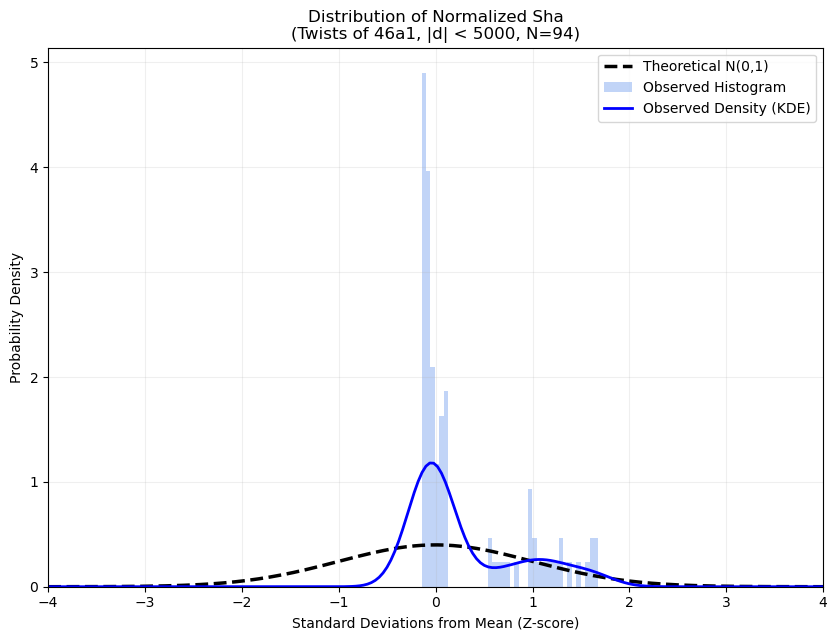

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde
import signal
import imageio.v2 as imageio
import os

# --- 1. DATA GENERATION ---
# Same robust generator as before. 
# For a "Paper Quality" curve, you want max_d >= 5000 (takes ~1-2 mins).

def generate_z_scores(max_d):
    print(f"Generating data for |d| < {max_d}...")
    E = EllipticCurve('46a1')
    N = E.conductor()
    epsE = E.root_number()
    
    mu_E = -0.5 - 1.5 * np.log(2) 
    sigma_sq_E = 1.0 + 2.5 * (np.log(2)**2)
    
    data = [] 
    
    for d_val in range(1, max_d + 1):
        for sign in [1, -1]:
            d = sign * d_val
            
            if not is_fundamental_discriminant(d): continue
            if gcd(d, 2*N) != 1: continue
            if epsE * kronecker(d, -N) != 1: continue
            
            try:
                # Fast timeout
                if hasattr(signal, 'SIGALRM'): signal.alarm(1) 
                
                E_d = E.quadratic_twist(d)
                sha_an_float = E_d.sha().an(descent_second_limit=5)
                
                if hasattr(signal, 'SIGALRM'): signal.alarm(0)
                
                sha_int = int(round(sha_an_float))
                if sha_int < 1: continue 
                
                # Z-score (Standard Deviations from Mean)
                val = np.log(sha_int / np.sqrt(abs(d)))
                log_log_d = np.log(np.log(abs(d)))
                if log_log_d <= 0: continue 
                
                z = (val - (mu_E * log_log_d)) / np.sqrt(sigma_sq_E * log_log_d)
                data.append(z)
                
            except:
                continue
    return np.array(data)

# Generate the data (Use 5000+ for a smooth curve)
Z_SCORES = generate_z_scores(500)


# --- 2. DENSITY PLOT ---

def plot_density_comparison():
    if len(Z_SCORES) == 0:
        print("No data generated.")
        return

    plt.figure(figsize=(10, 7))
    
    # A. The Theoretical Standard Normal N(0,1)
    x_axis = np.linspace(-4, 4, 200)
    plt.plot(x_axis, norm.pdf(x_axis), 'k--', linewidth=2.5, label='Theoretical N(0,1)')
    
    # B. The Empirical Data (Histogram + Density Estimate)
    # 1. Histogram (The raw bars)
    plt.hist(Z_SCORES, bins=40, density=True, color='cornflowerblue', alpha=0.4, label='Observed Histogram')
    
    # 2. KDE (The smooth blue line approximating the data)
    # This helps see the shape better than just bars
    kde = gaussian_kde(Z_SCORES)
    plt.plot(x_axis, kde(x_axis), 'b-', linewidth=2, label='Observed Density (KDE)')
    
    # Labels corresponding to N(0,1) axes
    plt.title(f"Distribution of Normalized Sha\n(Twists of 46a1, |d| < 500, N={len(Z_SCORES)})")
    plt.xlabel("Standard Deviations from Mean (Z-score)")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.xlim(-4, 4)
    
    plt.show()

plot_density_comparison()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde
import signal

# Ensure output directories exist
os.makedirs("output/frames", exist_ok=True)

# --- 1. DATA GENERATION (Unchanged) ---
def generate_z_scores(max_d):
    print(f"Generating data for |d| < {max_d}...")
    E = EllipticCurve('46a1')
    N = E.conductor()
    epsE = E.root_number()
    
    mu_E = -0.5 - 1.5 * np.log(2) 
    sigma_sq_E = 1.0 + 2.5 * (np.log(2)**2)
    
    data = [] 
    
    # Iterate through twists
    for d_val in range(1, max_d + 1):
        for sign in [1, -1]:
            d = sign * d_val
            
            if not is_fundamental_discriminant(d): continue
            if gcd(d, 2*N) != 1: continue
            if epsE * kronecker(d, -N) != 1: continue
            
            try:
                # Fast timeout
                if hasattr(signal, 'SIGALRM'): signal.alarm(1) 
                
                E_d = E.quadratic_twist(d)
                sha_an_float = E_d.sha().an(descent_second_limit=5)
                
                if hasattr(signal, 'SIGALRM'): signal.alarm(0)
                
                sha_int = int(round(sha_an_float))
                if sha_int < 1: continue 
                
                val = np.log(sha_int / np.sqrt(abs(d)))
                log_log_d = np.log(np.log(abs(d)))
                if log_log_d <= 0: continue 
                
                z = (val - (mu_E * log_log_d)) / np.sqrt(sigma_sq_E * log_log_d)
                
                # Store absolute d so we can filter later
                data.append( (abs(d), z) )
                
            except:
                continue
    # Sort by |d| so we can slice easily
    data.sort(key=lambda x: x[0])
    return data

# --- 2. THE FIXED-AXIS PLOTTER ---

def create_frame(all_data, current_max_d, output_filename=None):
    """
    Plots the distribution for twists with |d| <= current_max_d.
    Enforces FIXED AXES to allow for smooth animation.
    """
    
    # Filter data for this frame
    # We take all points where |d| <= current_max_d
    subset_z = [z for (d_abs, z) in all_data if d_abs <= current_max_d]
    subset_z = np.array(subset_z)
    
    plt.figure(figsize=(10, 7))
    
    # A. Theoretical N(0,1)
    x_axis = np.linspace(-4, 4, 200)
    plt.plot(x_axis, norm.pdf(x_axis), 'k--', linewidth=2.5, label='Theoretical N(0,1)')
    
    # B. Empirical Data
    if len(subset_z) > 10:
        # 1. Histogram with FIXED BINS
        # Using fixed bins ensures bars don't jump width between frames
        fixed_bins = np.linspace(-4, 4, 40) 
        plt.hist(subset_z, bins=fixed_bins, density=True, color='cornflowerblue', alpha=0.4, label='Observed Histogram')
        
        # 2. KDE
        try:
            kde = gaussian_kde(subset_z)
            plt.plot(x_axis, kde(x_axis), 'b-', linewidth=2, label='Observed Density (KDE)')
        except:
            pass # KDE can fail if data is too sparse or singular
            
    # --- C. THE CRITICAL PART: FIXED AXES ---
    plt.xlim(-4, 4)
    
    # The peak of N(0,1) is ~0.4. 
    # Noisy data often spikes to 0.6 or 0.8. We fix this to prevent jumping.
    plt.ylim(0, 0.75) 
    
    plt.title(f"Distribution of Normalized Sha\n(Twists of 46a1, |d| < {current_max_d}, N={len(subset_z)})")
    plt.xlabel("Standard Deviations from Mean (Z-score)")
    plt.ylabel("Probability Density")
    plt.legend(loc='upper right') # Fix legend location
    plt.grid(True, alpha=0.2)
    
    # Save or Show
    if output_filename:
        plt.savefig(output_filename, dpi=150)
        plt.close() # Close memory to prevent leaks during loop
        print(f"Saved {output_filename}")
    else:
        plt.show()

# --- 3. EXECUTION ---

# Step 1: Generate a LARGE pool of data once (e.g., up to 2000)
# (In reality, generate up to 10,000 or more)
FULL_DATA = generate_z_scores(1000)

# Step 2: Generate frames for the animation
# We'll create 4 plots as examples: X=200, 500, 1000, 2000
checkpoints = [200, 400, 600, 800, 1000]

for val in checkpoints:
    print(f"Creating plot for X={val}...")
    create_frame(FULL_DATA, val) 
    # To save images for animation, use:
    create_frame(FULL_DATA, val, output_filename=f"output/frames/frame_{val}.png")

In [ ]:
def create_slow_gif(checkpoints, output_name, duration_sec):
    images = []
    print(f"Reading {len(checkpoints)} frames...")
    
    for val in checkpoints:
        filename = f"output/frames/frame_{val}.png"
        if os.path.exists(filename):
            images.append(imageio.imread(filename))
            
    # Save with explicit loop and duration
    # loop=0 means loop forever
    imageio.mimsave(output_name, images, duration=duration_sec, loop=0)
    print(f"Saved {output_name} (Speed: {duration_sec} seconds per frame)")

# Run this: 
# 0.5 = half a second per frame (moderate)
# 1.0 = one second per frame (slow)
create_slow_gif(checkpoints, "output/convergence_slow.gif", duration_sec=5)

In [4]:
pip install imageio

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from IPython.display import Image
Image(filename="output/convergence_slow.gif")

In [22]:
from matplotlib import animation
from IPython.display import HTML

# Setup the figure
fig, ax = plt.subplots(figsize=(10, 7))

def update(frame_idx):
    ax.clear()
    
    # 1. Get current X limit
    current_X = checkpoints[frame_idx]
    
    # 2. Filter data for this frame
    subset_z = [z for (d_abs, z) in FULL_DATA if d_abs <= current_X]
    subset_z = np.array(subset_z)
    N = len(subset_z)

    # 3. Plot Theory (Black Dashed)
    x_axis = np.linspace(-4, 4, 200)
    ax.plot(x_axis, norm.pdf(x_axis), 'k--', linewidth=2.5, label='Conjecture (Standard Normal)')
    
    # 4. Plot Empirical (Blue)
    if N > 10:
        # Fixed bins for stability
        fixed_bins = np.linspace(-4, 4, 40)
        ax.hist(subset_z, bins=fixed_bins, density=True, color='cornflowerblue', alpha=0.4, label='Observed Histogram')
        
        # KDE (Smooth line)
        try:
            kde = gaussian_kde(subset_z)
            ax.plot(x_axis, kde(x_axis), 'b-', linewidth=2.5, label='Observed Density (KDE)')
        except: pass
        
    # 5. Styling
    ax.set_xlim(-4, 4)
    ax.set_ylim(0, 0.75) # Fixed Y-limit prevents jumping
    ax.grid(True, alpha=0.2)
    ax.legend(loc='upper right', framealpha=0.9)
    
    ax.set_xlabel("Normalized Discrepancy (Z-score)")
    ax.set_ylabel("Probability Density")
    
    # --- IMPROVED TITLE ---
    # We use a multi-line title for clarity
    title_str = (
        r"$\bf{Radziwiłł-Soundararajan\ Conjecture\ Verification\ (46a1)}$" + "\n" +
        f"Discriminant Bound: $|d| < {current_X}$   |   Sample Size: $N = {N}$"
    )
    ax.set_title(title_str, fontsize=14)

# Create Animation
# interval=1000 means 1 second per frame (slow and clear)
ani = animation.FuncAnimation(fig, update, frames=len(checkpoints), interval=1000)
plt.close() # Prevent double plotting

# Render as HTML5 Video
HTML(ani.to_jshtml())

In [ ]:
# Generate the HTML content string
html_content = ani.to_jshtml()

# Save it to a file
filename = "output/rs_conjecture_convergence.html"
with open(filename, "w") as f:
    f.write(html_content)

print(f"Success! Saved animation to '{filename}'.")
print("You can now download this file and share it.")